##**LIBRARY**

In [ ]:
pip install -U nltk

In [ ]:
pip install torchmetrics

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from gensim.models import Word2Vec
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchsummary import summary
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

lemma = WordNetLemmatizer()
lb = LabelEncoder()


In [ ]:
import spacy
from spacy import displacy
spacy.cli.download("en_core_web_lg")

nlp=spacy.load("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#**PRE_PROCESSING**

In [ ]:
dataset = pd.read_excel('/content/Data Bully Dimas TI.xlsx')
dataset.head()

,full_text,Label,tweet_url
0,minimal kl gue editin cari materinya lah ajg u...,Bully,https://twitter.com/cook1iejar/status/17057336...
1,jamur ðŸ_x008d_„: ngapain sih ikut becky ke lu...,Bully,https://twitter.com/nindy113/status/1705733387...
2,"@moviemenfes susi saha anjing?? btw galang, sa...",Nobully,https://twitter.com/sluttheryne/status/1705733...
3,Gini amat Jadi Tim Gede pemegang 20 Gelar Liga...,Nobully,https://twitter.com/yourPizzaaaaa/status/17057...
4,@Zaim72790295 @PDI_Perjuangan Lah ini anjing l...,Nobully,https://twitter.com/SzZelo/status/170573330941...


In [ ]:
dataset.isnull().sum()

full_text    0
Label        0
tweet_url    0
dtype: int64

In [ ]:
print(dataset['Label'].value_counts())

Nobully           1099
Bully              339
Nobully­             4
Nobully_x009d_       2
Nobullly             2
Nobully_x0081_       2
Bully˜               1
Buly                 1
Nobul­ly             1
Nobully˜             1
Bully                1
Nobully_x008d_       1
Bully­               1
Name: Label, dtype: int64


In [ ]:
def clean_label(label):
    label = label.lower()  # Mengubah label menjadi lowercase
    label = re.sub(r'[^\w\s]', '', label)  # Menghapus karakter non-alphanumerik
    label = re.sub(r'\bno+\b', 'nobully', label)  # Menggabungkan 'no' menjadi 'nobully'
    label = re.sub(r'\b(bul+)\b', 'bully', label)  # Menggabungkan 'bul' menjadi 'bully'
    return label

# Membersihkan label pada kolom 'Label'
dataset['Label'] = dataset['Label'].apply(clean_label)

In [ ]:
# Mapping label yang akan diubah
label_mapping = {
    'nobullly': 'nobully',
    'buly': 'bully',
    'nobully_x009d_': 'nobully',
    'nobully_x0081_': 'nobully',
    'nobully_x008d_': 'nobully'
}

# Update label sesuai dengan mapping
dataset['Label'] = dataset['Label'].replace(label_mapping)

# Mengubah label menjadi lowercase dan menghapus karakter non-alfanumerik
dataset['Label'] = dataset['Label'].str.lower().str.replace(r'[^a-zA-Z0-9]', '')

In [ ]:
np.unique(dataset['Label'])

array(['bully', 'nobully'], dtype=object)

In [ ]:
def Most_Words_used(full_text , num_of_words) :
    all_text = ''.join(dataset[full_text].values)

    all_text = re.sub(r'http\S+', '', all_text)
    all_text = re.sub(r'@\S+', '', all_text)
    all_text = re.sub(r'#\S+', '', all_text)
    all_text = re.sub(r'\d+', '',all_text)
    all_text = re.sub(r'[^\w\s]', '',all_text)
    all_text = re.sub(r'\p{Emoji}', '', full_text)

    words = all_text.split()

    stop_words = set(stopwords.words('indonesian'))
    words = [word for word in words if not word in stop_words]

    word_counts = Counter(words)

    top_words = word_counts.most_common(num_of_words)

    return top_words

In [ ]:
def DataPrep(full_text) :
    full_text = re.sub('<.*?>', '', full_text)
    full_text = re.sub(r'http\S+', '', full_text)
    full_text = re.sub(r'@\S+', '', full_text)
    full_text = re.sub(r'#\S+', '', full_text)
    full_text = re.sub(r'\d+', '', full_text)
    full_text = re.sub(r'[^\w\s]', '', full_text)
    full_text = re.sub(r'@(\w+)', '', full_text)
    full_text = re.sub(r'_\S+', '', full_text)
    tokens = nltk.word_tokenize(full_text)

    #remove puncs
    punc = list(punctuation)
    words = [w for w in tokens if w not in punc]

    #remove stop words
    stop_words = set(stopwords.words('indonesian'))
    words = [w.lower() for w in words if not w.lower() in stop_words]

    # lemmatization
    words = [lemma.lemmatize(w) for w in words]

    text = ' '.join(words)

    return text

In [ ]:
dataset['full_text'] = dataset['full_text'].astype(str).apply(DataPrep)

In [ ]:
def remove_non_ascii(text):
    return ''.join([i if ord(i) < 128 else '' for i in text])

# Apply the function to remove emojis in the 'Text' column
dataset['full_text'] = dataset['full_text'].apply(remove_non_ascii)

# Display the modified DataFrame
print(dataset['full_text'])

0       minimal kl gue editin cari materinya ajg udh t...
1       jamur  ngapain sih becky negerimending tiduran...
2                susi saha anjing btw galang sampe galang
3       gini tim gede pemegang gelar liga inggris keli...
4                                         anjing ngetweet
                              ...                        
1450                                                     
1451                                            kak udikk
1452                                                udikk
1453                         mainan nya bokep bokep udikk
1454                                           betuludikk
Name: full_text, Length: 1455, dtype: object


In [ ]:
print(dataset['full_text'])

0       minimal kl gue editin cari materinya ajg udh t...
1       jamur  ngapain sih becky negerimending tiduran...
2                susi saha anjing btw galang sampe galang
3       gini tim gede pemegang gelar liga inggris keli...
4                                         anjing ngetweet
                              ...                        
1450                                                     
1451                                            kak udikk
1452                                                udikk
1453                         mainan nya bokep bokep udikk
1454                                           betuludikk
Name: full_text, Length: 1455, dtype: object


In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 155 duplicated tweets, we will remove them.


In [ ]:
dataset.drop_duplicates("full_text", inplace=True)

In [ ]:
print(f'There are around {int(dataset["full_text"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 0 duplicated tweets, we will remove them.


In [ ]:
print(dataset['full_text'])

0       minimal kl gue editin cari materinya ajg udh t...
1       jamur  ngapain sih becky negerimending tiduran...
2                susi saha anjing btw galang sampe galang
3       gini tim gede pemegang gelar liga inggris keli...
4                                         anjing ngetweet
                              ...                        
1449    gile okep pgn dilegalkan mbokkk udikk oon kabi...
1451                                            kak udikk
1452                                                udikk
1453                         mainan nya bokep bokep udikk
1454                                           betuludikk
Name: full_text, Length: 1300, dtype: object


#**SPLIT DATASET**

In [ ]:
pip install rank_bm25

In [ ]:
import pandas as pd
#preprocesing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re
#split data
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import CountVectorizer
# bm25
from rank_bm25 import BM25Okapi
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np



In [ ]:
# Membuat DataFrame dari data sentimen
dataset= pd.DataFrame(dataset)

In [ ]:
X = dataset['full_text'].tolist()
y = dataset['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Jumlah data latih
num_train = len(X_train)
print("Jumlah data latih:", num_train)

# Jumlah data uji
num_test = len(X_test)
print("Jumlah data uji:", num_test)

Jumlah data latih: 1040
Jumlah data uji: 260


In [ ]:
dataset = dataset.dropna(subset=['full_text'])

# Extract the 'text' column as a list again
X_train = dataset['full_text'].tolist()

# Define n-gram range
ngram_range = (1, 2)

# Initialize CountVectorizer
vectorizer = CountVectorizer(ngram_range=ngram_range)

# Fit and transform the data
X_train_counts = vectorizer.fit_transform(X_train)

In [ ]:
df_counts = pd.DataFrame(X_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
print(df_counts)

      aaa  aaa bangsatt  aaaa  aaaa konser  aaaaaa  aaaaaa diwnsiiwis  \
0       0             0     0            0       0                  0   
1       0             0     0            0       0                  0   
2       0             0     0            0       0                  0   
3       0             0     0            0       0                  0   
4       0             0     0            0       0                  0   
...   ...           ...   ...          ...     ...                ...   
1295    0             0     0            0       0                  0   
1296    0             0     0            0       0                  0   
1297    0             0     0            0       0                  0   
1298    0             0     0            0       0                  0   
1299    0             0     0            0       0                  0   

      aaaaaaa  aaaaaaa dah  aaaaaaaahhh  aaaaaaaahhh tahan  ...  zimudhidhi  \
0           0            0            0     

#**BM25**

In [ ]:
# Membangun BM25 Vectorizer
bm25 = BM25Okapi(X_train)

# Mengubah data pelatihan menjadi vektor BM25
X_train_bm25 = [bm25.get_scores(doc) for doc in X_train]

# Mengubah data uji menjadi vektor BM25
X_test_bm25 = [bm25.get_scores(doc) for doc in X_test]

# Menggabungkan X_train_bm25 dan X_test_bm25
X_train_bm25_combined = np.vstack(X_train_bm25)
X_test_bm25_combined = np.vstack(X_test_bm25)


#**WORD EMBEDDING**

In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [ ]:
# Melatih model Word2Vec
tokenized_text = dataset['full_text'].apply(lambda x: word_tokenize(x.lower()))
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, sg=0)

In [ ]:
# Membuat fungsi untuk mengonversi teks menjadi representasi vektor Word2Vec
def text_to_vector(text, model):
    words = word_tokenize(text.lower())
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        text_vector = sum(word_vectors) / len(word_vectors)
    else:
        text_vector = [0] * model.vector_size
    return text_vector

In [ ]:
# Mengonversi teks menjadi representasi vektor Word2Vec
dataset['text_vectors'] = dataset['full_text'].apply(lambda x: text_to_vector(x, word2vec_model))

In [ ]:
# Memisahkan dataset menjadi data latih dan data uji
X = dataset['text_vectors'].tolist()  # Features
y = dataset['Label']  # Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()
model3 = RandomForestClassifier()
model4 = SVC(probability=True)

ensemble_model = VotingClassifier(estimators=[('lr', model1), ('dt', model2), ('rf', model3), ('svm', model4)], voting='soft')

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier()),
                             ('rf', RandomForestClassifier()),
                             ('svm', SVC(probability=True))],
                 voting='soft')

In [ ]:
# Membuat prediksi dengan model ensemble pada data uji
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)

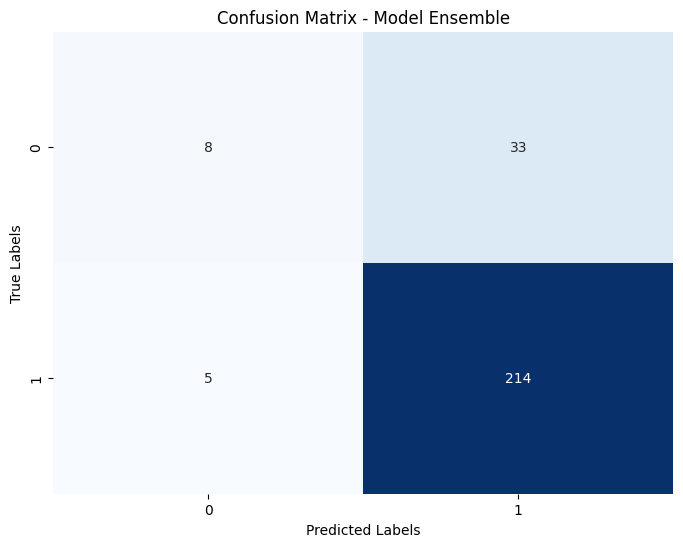

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_ensemble)


# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Model Ensemble")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Mengubah y_pred_ensemble menjadi array numpy
y_pred_ensemble = np.array(y_pred_ensemble)

# Memastikan jumlah sampel yang konsisten
min_len = min(len(y_test), len(y_pred_ensemble))
y_test = y_test[:min_len]
y_pred_ensemble = y_pred_ensemble[:min_len]

# Menampilkan metrik evaluasi
accuracy = accuracy_score(y_test, y_pred_ensemble)
precision = precision_score(y_test, y_pred_ensemble, average='weighted')
recall = recall_score(y_test, y_pred_ensemble, average='weighted')
f1 = f1_score(y_test, y_pred_ensemble, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8538461538461538
Precision: 0.8268140766116474
Recall: 0.8538461538461538
F1-score: 0.820345304036291


In [ ]:
train_acc1 = ensemble_model.score(X_train , y_train)
print(f"The training accuracy for Ensemble Learning : {(train_acc1*100):0.2f}%")

The training accuracy for Ensemble Learning : 99.62%


# **RANDOM FOREST**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train , y_train)

RandomForestClassifier()

In [ ]:
train_acc1 = rf.score(X_train , y_train)

In [ ]:
rf_pred = rf.predict(X_test)

test_acc1 = accuracy_score(y_test , rf_pred)
test_precision1 = precision_score(y_test , rf_pred , average='weighted')
test_recall1 = recall_score(y_test , rf_pred , average='weighted')
test_f1score1 = f1_score(y_test , rf_pred , average='weighted')

In [ ]:
print(f"The training accuracy for random forest : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for random forest : {(test_acc1*100):0.2f}%\n")
print(f"The precision for random forest : {test_precision1:0.2f}\n")
print(f"The recall for random forest : {test_recall1:0.2f}\n")
print(f"The f1 score for random forest : {test_f1score1:0.2f}\n")

The training accuracy for random forest : 99.90%

The testing accuracy for random forest : 85.77%

The precision for random forest : 0.88

The recall for random forest : 0.86

The f1 score for random forest : 0.80



#**LOGISTIC REGRESSION**

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train , y_train)

LogisticRegression(random_state=42)

In [ ]:
train_acc1 = lr.score(X_train , y_train)

In [ ]:
lr_pred = lr.predict(X_test)

test_acc1 = accuracy_score(y_test , lr_pred)

test_precision1 = precision_score(y_test , lr_pred , average='weighted')
test_recall1 = recall_score(y_test , lr_pred , average='weighted')
test_f1score1 = f1_score(y_test , lr_pred , average='weighted')

In [ ]:
print(f"The training accuracy for logistic regression : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for logistic regression : {(test_acc1*100):0.2f}%\n")
print(f"The precision for logistic regression : {test_precision1:0.2f}\n")
print(f"The recall for logistic regression : {test_recall1:0.2f}\n")
print(f"The f1 score for logistic regression : {test_f1score1:0.2f}\n")

The training accuracy for logistic regression : 78.65%

The testing accuracy for logistic regression : 84.23%

The precision for logistic regression : 0.71

The recall for logistic regression : 0.84

The f1 score for logistic regression : 0.77



#**SUPPORT VECTOR MACHINE**

In [ ]:
model4 = SVC(probability=True, random_state=42)
model4.fit(X_train , y_train)

SVC(probability=True, random_state=42)

In [ ]:
train_acc1 = model4.score(X_train , y_train)

In [ ]:
model4_pred = model4.predict(X_test)

test_acc1 = accuracy_score(y_test , model4_pred)

test_precision1 = precision_score(y_test , model4_pred , average='weighted')
test_recall1 = recall_score(y_test , model4_pred , average='weighted')
test_f1score1 = f1_score(y_test , model4_pred , average='weighted')

In [ ]:
print(f"The training accuracy for SVC : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for SVC : {(test_acc1*100):0.2f}%\n")
print(f"The precision for SVC : {test_precision1:0.2f}\n")
print(f"The recall for SVC : {test_recall1:0.2f}\n")
print(f"The f1 score for SVC : {test_f1score1:0.2f}\n")

The training accuracy for SVC : 84.04%

The testing accuracy for SVC : 85.38%

The precision for SVC : 0.85

The recall for SVC : 0.85

The f1 score for SVC : 0.80



In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train , y_train)

DecisionTreeClassifier()

In [ ]:
train_acc1 = dt.score(X_train , y_train)

In [ ]:
dt_pred = dt.predict(X_test)

test_acc1 = accuracy_score(y_test , dt_pred)

test_precision1 = precision_score(y_test , dt_pred , average='weighted')
test_recall1 = recall_score(y_test , dt_pred , average='weighted')
test_f1score1 = f1_score(y_test , dt_pred , average='weighted')

In [ ]:
print(f"The training accuracy for Decision Tree : {(train_acc1*100):0.2f}%\n")
print(f"The testing accuracy for Decision Tree : {(test_acc1*100):0.2f}%\n")
print(f"The precision for Decision Tree : {test_precision1:0.2f}\n")
print(f"The recall for Decision Tree : {test_recall1:0.2f}\n")
print(f"The f1 score for Decision Tree : {test_f1score1:0.2f}\n")

The training accuracy for Decision Tree : 99.90%

The testing accuracy for Decision Tree : 66.92%

The precision for Decision Tree : 0.75

The recall for Decision Tree : 0.67

The f1 score for Decision Tree : 0.70

